In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Normal Linear Regression

I will not derive normal Linear Regression here, but it would work over MLE with a Gaussian Likelihood.

In [9]:
from linear_models import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

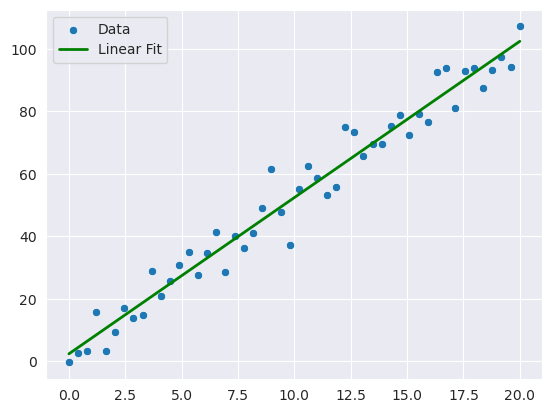

In [10]:
x = np.linspace(0, 20, 50)
y = 5 * x + 3 + np.random.randn(50) * 7

mdl = LinearRegression().fit(x.reshape(-1, 1), y)
x_reg_line = np.linspace(0, 20, 200)
y_reg_line = x_reg_line.reshape(-1, 1) @ mdl.coef_ + mdl.intercept_

sns.scatterplot(x=x, y=y, label="Data")
plt.plot(x_reg_line, y_reg_line, label="Linear Fit", color="green", linewidth=2)
plt.legend()
plt.show()

Of course the problem from the example above is that it could not capture any more complex relationships. However, we can transform our input
data (X) with basis functions and through this technique we can capture ever more complex relationships. *(Note: You can also learn the basis
functions: This is exactly what deep learning does. You have the first layers, which represent the basis functions, and the last layer is
then again the normal regression or classification layer)*

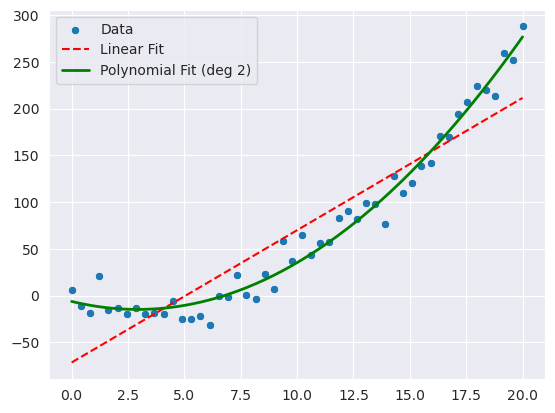

In [11]:
x = np.linspace(0, 20, 50)
y = x**2 - 6 * x - 3 + np.random.randn(50) * 15
X = x.reshape(-1, 1)
x_plot = np.linspace(0, 20, 200).reshape(-1, 1)

mdl1 = LinearRegression().fit(X, y)
y_reg_line = mdl1.predict(x_plot)

mdl2 = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
mdl2.fit(X, y)
y_reg_line2 = mdl2.predict(x_plot)

sns.scatterplot(x=x, y=y, label="Data")
plt.plot(x_plot, y_reg_line, label="Linear Fit", color="red", linestyle="--")
plt.plot(x_plot, y_reg_line2, label="Polynomial Fit (deg 2)", color="green", linewidth=2)
plt.legend()
plt.show()

# Robust Regression

We assume the target $y_i$ follows a Laplace distribution centered at the model prediction $f_w(x_i)$ with scale parameter $\beta^{-1}$.
$$y_i \sim \text{Laplace}(f_w(x_i), \beta^{-1})$$

The probability density function is given by:
$$p(y_i \mid f_w(x_i), \beta) = \text{Laplace}(y_i \mid f_w(x_i), \beta^{-1}) = \frac{\beta}{2} \exp\left(-\beta |y_i - f_w(x_i)|\right)$$

Now we do a MLE Derivation:
$$
\begin{aligned}
w_{MLE}, \beta_{MLE} &= \underset{w, \beta}{\text{argmax}} \ p(y \mid X, w, \beta) \\
&= \underset{w, \beta}{\text{argmax}} \ \log p(y \mid X, w, \beta) \\
&= \underset{w, \beta}{\text{argmin}} \ -\log p(y \mid X, w, \beta)
\end{aligned}
$$
Assuming iid samples:
$$
\begin{aligned}
&= \underset{w, \beta}{\text{argmin}} \ -\log \left( \prod_{i=1}^{N} \text{Laplace}(y_i \mid \phi(x_i), \beta^{-1}) \right) \\
&= \underset{w, \beta}{\text{argmin}} \ -\log \left( \prod_{i=1}^{N} \frac{\beta}{2} \exp\left(-\frac{|y_i - w^\top \phi(x_i)|}{\beta^{-1}}\right) \right) \\
&= \underset{w, \beta}{\text{argmin}} \ - \left( N \log\left(\frac{\beta}{2}\right) - \beta \sum_{i=1}^{N} |w^\top \phi(x_i) - y_i| \right) \\
&= \underset{w, \beta}{\text{argmin}} \ \left[ -N \log\left(\frac{\beta}{2}\right) + \beta \sum_{i=1}^{N} |w^\top \phi(x_i) - y_i| \right] = \underset{w, \beta}{\text{argmin}} \ E_{MLE}(w, \beta)
\end{aligned}
$$

To find $w_{MLE}$, we can ignore terms that do not depend on $w$ and positive constant multipliers ($\beta$):
$$
\begin{aligned}
w_{MLE} &= \underset{w}{\text{argmin}} \ E_{MLE}(w, \beta) \\
&= \underset{w}{\text{argmin}} \sum_{i=1}^{N} |w^\top \phi(x_i) - y_i| = \underset{w}{\text{argmin}} \ E_{LAD}(w)
\end{aligned}
$$
Here we can see that this probabilistic derivation approach got us the same result as directly modeling the $E_{LAD}$ Loss.

Since the absolute value function is not differentiable at zero, we reformulate the problem as a linear program
by introducing slack variables $e_i$.
$$\underset{w, e}{\text{argmin}} \sum_{i=1}^{N} e_i$$
**subject to constraints:**
For all $i=1 \dots N$:
$$e_i \ge w^\top \phi(x_i) - y_i$$
**and:**
$$e_i \ge -(w^\top \phi(x_i) - y_i)$$
*(These two constraints together ensure $e_i \ge |w^\top \phi(x_i) - y_i|$).*

And then we can use a linear programming solver to minimize this problem.

In [12]:
from linear_models import RobustRegression

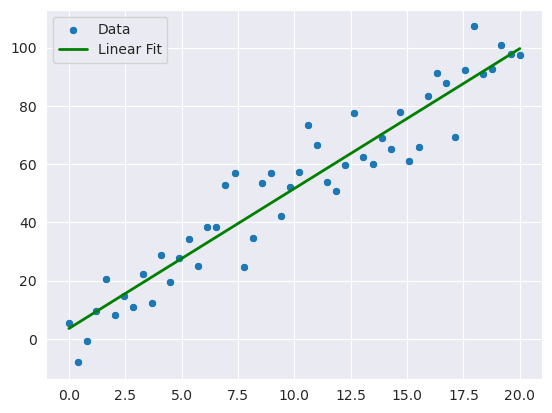

In [13]:
x = np.linspace(0, 20, 50)
y = 5 * x + 3 + np.random.randn(50) * 9

mdl = RobustRegression().fit(x.reshape(-1, 1), y)
x_reg_line = np.linspace(0, 20, 200)
y_reg_line = x_reg_line.reshape(-1, 1) @ mdl.coef_ + mdl.intercept_

sns.scatterplot(x=x, y=y, label="Data")
plt.plot(x_reg_line, y_reg_line,  label="Linear Fit", color="green", linewidth=2)
plt.legend()
plt.show()


Again, we can use basis functions to transform the input data and get non-linear relationships in the input data.

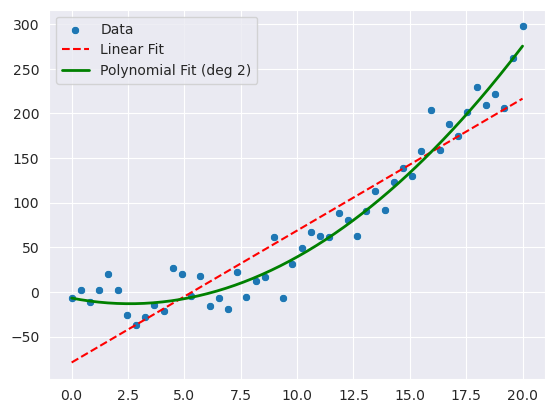

In [14]:
x = np.linspace(0, 20, 50)
y = x**2 - 6 * x - 3 + np.random.randn(50) * 20
X = x.reshape(-1, 1)
x_plot = np.linspace(0, 20, 200).reshape(-1, 1)

mdl1 = RobustRegression().fit(X, y)
y_reg_line = mdl1.predict(x_plot)

mdl2 = make_pipeline(PolynomialFeatures(degree=2), RobustRegression())
mdl2.fit(X, y)
y_reg_line2 = mdl2.predict(x_plot)

sns.scatterplot(x=x, y=y, label="Data")
plt.plot(x_plot, y_reg_line, label="Linear Fit", color="red", linestyle="--")
plt.plot(x_plot, y_reg_line2, label="Polynomial Fit (deg 2)", color="green", linewidth=2)
plt.legend()
plt.show()


## Ridge Regression

I won't derive ridge regression here, but it works by assuming a Gaussian Likelihood and an Isotropic Gaussian prior with mean 0.
But the more interesting question is, why even use Ridge Regression and not just normal regression. The problem with normal linear regression is
that if you make your polynomial too high, it overfits quite quickly. In the example below, I plotted once Linear Regression with a
degree 9 polynomial as a basis function (green line) and there we can see that it overfits completely. The problem turned from a regression to
an interpolation problem. Of course this here is an extreme example, but even if you would have more datapoints and choose a polynomial
with high degree, it would wiggle more due to the noise. But through the L2 Normalization constrained, it gets dampened. We can see this with
the blue line. Here we use a rather large normalization constant of 1e5 as this is such an extreme example of overfitting that this is necessary.
Lasso Regression and L4 Regression have both the same idea, but they use different norms to penalize the loss.

However, if we had set alpha=0 in the ridge regression we would have got normal linear regression again.


In [15]:
from linear_models import RidgeRegression

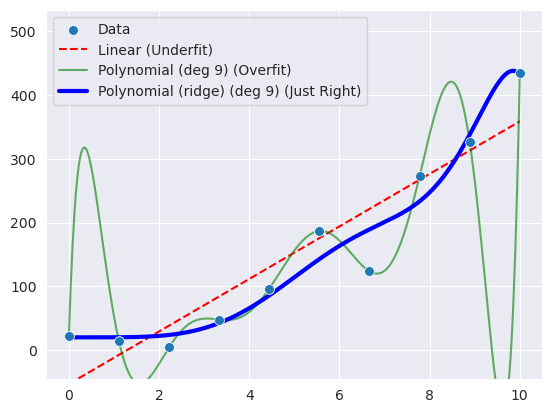

In [16]:
np.random.seed(70)
x = np.linspace(0, 10, 10)
y = 4 * x**2 + 6 * x - 3 + np.random.randn(10) * 30
X = x.reshape(-1, 1)
x_plot = np.linspace(0,10, 500).reshape(-1, 1)

mdl1 = LinearRegression().fit(X, y)
y_reg_line = mdl1.predict(x_plot)

mdl2 = make_pipeline(PolynomialFeatures(degree=9), LinearRegression())
mdl2.fit(X, y)
y_reg_line2 = mdl2.predict(x_plot)

mdl3 = make_pipeline(PolynomialFeatures(degree=9, include_bias=False), RidgeRegression(alpha=1e5))
mdl3.fit(X, y)
y_reg_line3 = mdl3.predict(x_plot)


sns.scatterplot(x=x, y=y, label="Data", s=50, zorder=5)
plt.plot(x_plot, y_reg_line, label="Linear (Underfit)", color="red", linestyle="--")
plt.plot(x_plot, y_reg_line2, label="Polynomial (deg 9) (Overfit)", color="green", alpha=0.6)
plt.plot(x_plot, y_reg_line3, label="Polynomial (ridge) (deg 9) (Just Right)", color="blue", linewidth=3)
plt.legend()
plt.ylim(min(y)-50, max(y)+100)
plt.show()

## Lasso Regression

For Lasso Regression we assume a Gaussian Likelihood
$$p(y_i \mid f_w(x_i), \beta) = \mathcal{N}(y_i \mid f_w(x_i), \beta^{-1})$$
where $\beta$ is the precision (inverse variance)
and a Laplace Prior
$$p(w_j \mid \alpha) = \text{Laplace}(w_j \mid 0, \alpha^{-1}) = \frac{\alpha}{2} \exp(-\alpha |w_j|)$$
Assuming the weights are iid (we do this here as this is the same as choosing an isotropic covariance matrix for the multivariate laplacian.
Which we need to get the L1-Normalization. This assumption of course doesn't allow for more elaborate priors, which we could have used if we
derived it with a Multivariate Laplacian and a general covariance matrix.)
$$p(w \mid \alpha) = \prod_{j=1}^{D} p(w_j \mid \alpha)$$
Using Bayes' Theorem, the posterior distribution is:
$$p(\mathbf{w} \mid \mathbf{X}, \mathbf{y}, \beta, \alpha) \propto p(\mathbf{y} \mid \mathbf{X}, \mathbf{w}, \beta) \cdot p(\mathbf{w} \mid \alpha)$$
To find the optimal weights $\hat{\mathbf{w}}$, we minimize the negative log-posterior, since we are doing a MAP estimation:
$$\begin{align*}
\hat{\mathbf{w}} &= \arg\min_{\mathbf{w}} -\log p(\mathbf{w} \mid \mathbf{X}, \mathbf{y}, \beta, \alpha) \\
&= \arg\min_{\mathbf{w}} -\sum_{i=1}^{N} \log \mathcal{N}(y_i \mid \mathbf{w}^\top \mathbf{x}_i, \beta^{-1}) - \sum_{j=1}^{D} \log \text{Laplace}(w_j \mid 0, \alpha^{-1})
\end{align*}$$
Substitutin the PDFS and dropping constants independent of $\mathbf{w}$ we get:
$$\begin{align*}
\hat{\mathbf{w}} &= \arg\min_{\mathbf{w}} \sum_{i=1}^{N} \frac{\beta}{2} (y_i - \mathbf{w}^\top \mathbf{x}_i)^2 + \sum_{j=1}^{D} \alpha |w_j|
\end{align*}$$
So let's define the Lasso Loss functions as follows, defining $\lambda = \frac{\alpha}{\beta}$:
$$E_{\text{Lasso}}(\mathbf{w}) = \frac{1}{2} \sum_{i=1}^{N} (y_i - \mathbf{w}^\top \mathbf{x}_i)^2 + \lambda \sum_{j=1}^{D} |w_j|$$
Now we can optimize this via Coordinate Descent.
Since the $L_1$ penalty is not differentiable at $w_j = 0$, we use subgradients to find the update rule for a single weight $w_j$, keeping all other weights $\mathbf{w}_{k \neq j}$ fixed.
Let the partial residual for the $j$-th feature be:
$$p_j = \sum_{i=1}^{N} x_{ij} \left( y_i - \sum_{k \neq j} w_k x_{ik} \right)$$
The optimality condition $\frac{\partial E}{\partial w_j} = 0$ leads to three cases
1. Case $w_j > 0$: $-p_j + w_j \sum_{i=1}^N x_{ij}^2 + \lambda = 0 \implies w_j = \frac{p_j - \lambda}{\sum x_{ij}^2} \quad (\text{if } p_j > \lambda)$
2. Case $w_j < 0$: $-p_j + w_j \sum_{i=1}^N x_{ij}^2 - \lambda = 0 \implies w_j = \frac{p_j + \lambda}{\sum x_{ij}^2} \quad (\text{if } p_j < -\lambda)$
3. Case $w_j = 0$: The subgradient includes zero if $|p_j| \leq \lambda$.

Combining these cases, the update rule for $w_j$ is given by the soft thresholding function:
$$w_j = \frac{S(p_j, \lambda)}{\sum_{i=1}^N x_{ij}^2}$$
where
$$S(p_j, \lambda) = \text{sign}(p_j) \cdot \max(0, |p_j| - \lambda)$$





In [17]:
from linear_models import LassoRegression

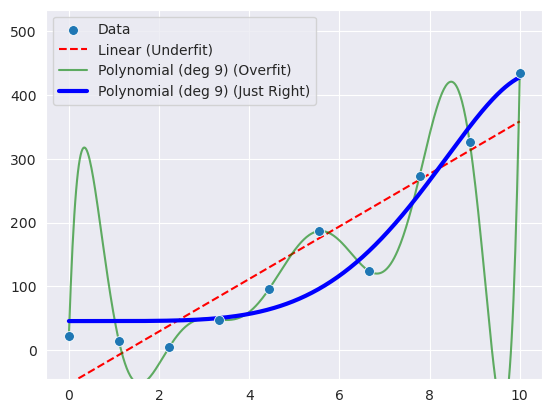

In [18]:
np.random.seed(70)
x = np.linspace(0, 10, 10)
y = 4 * x**2 + 6 * x - 3 + np.random.randn(10) * 30
X = x.reshape(-1, 1)
x_plot = np.linspace(0,10, 500).reshape(-1, 1)

mdl1 = LinearRegression().fit(X, y)
y_reg_line = mdl1.predict(x_plot)

mdl2 = make_pipeline(PolynomialFeatures(degree=9), LinearRegression())
mdl2.fit(X, y)
y_reg_line2 = mdl2.predict(x_plot)

mdl3 = make_pipeline(PolynomialFeatures(degree=9, include_bias=False), LassoRegression(lmbda=1e5))
mdl3.fit(X, y)
y_reg_line3 = mdl3.predict(x_plot)


sns.scatterplot(x=x, y=y, label="Data", s=50, zorder=5)
plt.plot(x_plot, y_reg_line, label="Linear (Underfit)", color="red", linestyle="--")
plt.plot(x_plot, y_reg_line2, label="Polynomial (deg 9) (Overfit)", color="green", alpha=0.6)
plt.plot(x_plot, y_reg_line3, label="Polynomial (deg 9) (Just Right)", color="blue", linewidth=3)
plt.legend()
plt.ylim(min(y)-50, max(y)+100)
plt.show()


## L4 Regression

For L4 Regression, we again assume a Gaussian as a Likelihood:
$$p(y_i \mid x_i, w, \beta) = \mathcal{N}(y_i \mid w^\top x_i, \beta^{-1})$$
So
$$p(y \mid X, w, \beta) = \prod_{i=1}^{N} \sqrt{\frac{\beta}{2\pi}} \exp\left( -\frac{\beta}{2} (y_i - w^\top x_i)^2 \right)$$
For the Prior we assume a Generalized Normal Distribution with shape parameter p = 4
$$p(w_j \mid \alpha) = \frac{4\alpha}{2\Gamma(1/4)} \exp\left( -\alpha^4 |w_j|^4 \right)$$
Again we assume that the weights are iid (for the same reason as with Lasso Regression):
$$p(w \mid \alpha) = \prod_{j=1}^{D} p(w_j \mid \alpha)$$

Then performing MAP estimation again, we get the posterior distribution through the Bayesian Rule:
$$p(w \mid X, y, \beta, \alpha) \propto p(y \mid X, w, \beta) \cdot p(w \mid \alpha)$$
Taking the negative log-posterior to find the minimum:
$$\hat{w} = \arg\min_{w} \left[ -\log p(y \mid X, w, \beta) - \log p(w \mid \alpha) \right]$$
Substituting the densities and dropping terms that do not depend on w, we get:
$$\hat{w} = \arg\min_{w} \left[ \sum_{i=1}^{N} \frac{\beta}{2} (y_i - w^\top x_i)^2 + \sum_{j=1}^{D} \alpha^4 w_j^4 \right]$$
Dividing by $\beta$ and letting $\lambda = \frac{\alpha^4}{\beta}$
$$E_{L_4}(w) = \frac{1}{2} \|y - Xw\|_2^2 + \lambda \|w\|_4^4$$
Finding the Gradient to use the L-BFGS-B Algorithm, we get:
$$\nabla E(w) = X^T X w - X^T y + 4 \lambda^3$$




In [19]:
from linear_models import L4Regression

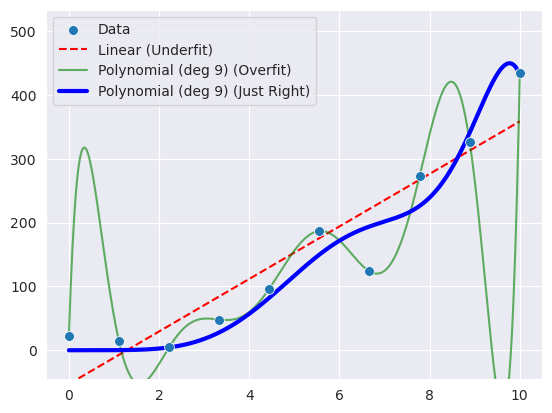

In [20]:
np.random.seed(70)
x = np.linspace(0, 10, 10)
y = 4 * x**2 + 6 * x - 3 + np.random.randn(10) * 30
X = x.reshape(-1, 1)
x_plot = np.linspace(0,10, 500).reshape(-1, 1)

mdl1 = LinearRegression().fit(X, y)
y_reg_line = mdl1.predict(x_plot)

mdl2 = make_pipeline(PolynomialFeatures(degree=9), LinearRegression())
mdl2.fit(X, y)
y_reg_line2 = mdl2.predict(x_plot)

mdl3 = make_pipeline(PolynomialFeatures(degree=9, include_bias=False), L4Regression(lmbda=1e5))
mdl3.fit(X, y)
y_reg_line3 = mdl3.predict(x_plot)


sns.scatterplot(x=x, y=y, label="Data", s=50, zorder=5)
plt.plot(x_plot, y_reg_line, label="Linear (Underfit)", color="red", linestyle="--")
plt.plot(x_plot, y_reg_line2, label="Polynomial (deg 9) (Overfit)", color="green", alpha=0.6)
plt.plot(x_plot, y_reg_line3, label="Polynomial (deg 9) (Just Right)", color="blue", linewidth=3)
plt.legend()
plt.ylim(min(y)-50, max(y)+100)
plt.show()


# Poisson Regression

The idea behind Poisson Regression is that we want to predict counts for example. But the variance is not constant, thus normal linear
regression even with a basis function would fail to capture the data. Thus, we assume that our data is poisson distributed and to get
the linear relationship into our data, we use the trick from generalized regression, that we put our linear function into a link function,
so that it adheres to the rules of the distribution. Then we set it equal to the expected value of our conditional distribution.

For Poisson Regression, we assume a Poisson Distribution as our Likelihood. To find the connection between our linear model and the distribution,
we use a link function:
$$\lambda_i = E[y_i \mid x_i] = \exp(w^\top x_i)$$
Then our likelihood becomes:
$$p(y_i \mid x_i, w) = \frac{\exp(w^\top x_i)^{y_i} \exp(-\exp(w^\top x_i))}{y_i!}$$
For the entire dataset we get:
$$p(y \mid X, w) = \prod_{i=1}^{N} \frac{\exp(w^\top x_i y_i) \exp(-\exp(w^\top x_i))}{y_i!}$$
Then we minimize the log-likelihood. After dropping the term $\log(y_i!)$ as it doesn't depend on w, we get our Loss function:
$$E_{Poi}(w) = -\sum_{i=1}^{N} \left[ y_i (w^\top x_i) - \exp(w^\top x_i) \right]$$
And our gradient is:
$$\nabla_w E_{Poi}(w) = \sum_{i=1}^{N} (\exp(w^\top x_i) - y_i) x_i$$
which we can use to perform the L-BFGS-B algorithm again to find the minimum.

In [21]:
from linear_models import PoissonRegression

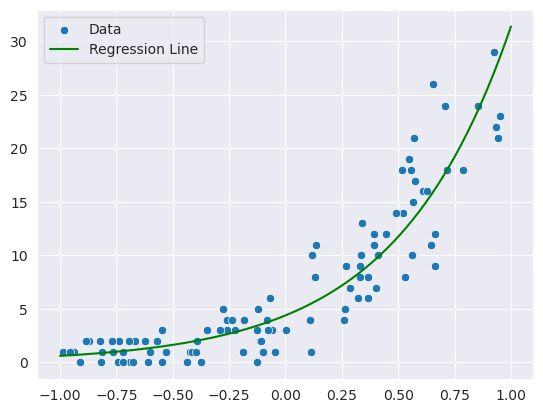

In [23]:
rng = np.random.default_rng(42)
X = rng.uniform(-1, 1, (100, 1))

z = X @ np.array([2]) + 1.5
mu = np.exp(z)
y = rng.poisson(mu).flatten()

x_plot = np.linspace(-1, 1, 300).reshape(-1, 1)

mdl1 = PoissonRegression().fit(X, y)
y_reg_line = mdl1.predict(x_plot)

sns.scatterplot(x=X.flatten(), y=y, label="Data")
plt.plot(x_plot, y_reg_line, label="Regression Line", color="green")
plt.legend()
plt.show()